# SkinLesion - Desafio ISIC 2019 - EfficientNets
Pré-treinadas com o ImageNet.

## Pipeline checklist

1. Configurações da *learning rate*;
2. Épocas de treinamento (inicial e final);
3. Callbacks durante o treinamento;
4. Nome do modelo a ser salvo (número da época final).


## To do:


* Trocar **MICRO** F1-score por *weighted* F1-score (p/ o treinamento final, p/ manter a consistência entre as métricas de comparação):
  * Da forma como a média micro é implementada, seus resultados são iguais (literalmente, os mesmos) aos da acurácia.
*   List item



## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# from keras import backend as K

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# !pip install tensorflow_addons
import tensorflow_addons as tfa

### Download dos arquivos do Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip files
!unzip "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/img_shades_cc.zip" -d "."

Streaming output truncated to the last 5000 lines.
  inflating: ./img_shades_cc/ISIC_0065329.jpg  
  inflating: ./img_shades_cc/ISIC_0066774_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0063650.jpg  
  inflating: ./img_shades_cc/ISIC_0033940.jpg  
  inflating: ./img_shades_cc/ISIC_0071678_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0027338.jpg  
  inflating: ./img_shades_cc/ISIC_0056929_aug1.jpg  
  inflating: ./img_shades_cc/ISIC_0061512.jpg  
  inflating: ./img_shades_cc/ISIC_0069094.jpg  
  inflating: ./img_shades_cc/ISIC_0064328_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0033524.jpg  
  inflating: ./img_shades_cc/ISIC_0024390.jpg  
  inflating: ./img_shades_cc/ISIC_0056193_aug2.jpg  
  inflating: ./img_shades_cc/ISIC_0028938.jpg  
  inflating: ./img_shades_cc/ISIC_0069119.jpg  
  inflating: ./img_shades_cc/ISIC_0029835.jpg  
  inflating: ./img_shades_cc/ISIC_0069321.jpg  
  inflating: ./img_shades_cc/ISIC_0060482.jpg  
  inflating: ./img_shades_cc/ISIC_0009884.jpg  
  inflating:

Abertura dos dataframes

In [3]:
# Open dataframes containing the images for training, validation and test
train_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_train.csv")

aug_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_train_aug2.csv")

val_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_val.csv")

test_df = pd.read_csv(
    r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/dataframes/isic2019_test.csv")

## Treinamento da arquitetura EfficientNet-***B2***

### Dependências
#### Métricas

In [4]:
# Multiclass F1-score MICRO Avg. TODO: remove for final release
micro_f1 = tfa.metrics.F1Score(
    num_classes=8,
    average='micro',
    name="Micro F1",
)

# Multiclass F1-score MACRO Avg.
macro_f1 = tfa.metrics.F1Score(
    num_classes=8,
    average='macro',
    name="Macro F1",
)

# Multiclass F1-score weighted (by the number of true instances in each class)
# average
weighted_f1 = tfa.metrics.F1Score(
    num_classes=8,
    average='weighted',
    name="Weighted F1",
)

#### Cálculo dos pesos das classes

In [5]:
# Compute class' weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(train_df.lesion),
                                     train_df.lesion)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 3.651359143327842, 1: 0.9528697334479793, 2: 1.206518780620577, 3: 13.271706586826348, 4: 0.7002764612954187, 5: 0.2459359742565468, 6: 5.037215909090909, 7: 12.521892655367232}


### Geradores dos tensores (**B2**)

In [6]:
IMG_SIZE = 260
BATCH_SIZE = 32

train_dataGen = ImageDataGenerator(rescale=1./255)

train_generator = train_dataGen.flow_from_dataframe(
    dataframe=aug_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

val_generator = train_dataGen.flow_from_dataframe(
    dataframe=val_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

test_generator = train_dataGen.flow_from_dataframe(
    dataframe=test_df, x_col='image_path', class_mode='raw', seed=31415,
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

Found 26450 validated image filenames.
Found 5066 validated image filenames.
Found 2534 validated image filenames.


### Instanciação da arquitetura

In [ ]:
# # Load EfficientNet pre-trained w/ ImageNet
# base_model = EfficientNetB2(include_top=False, weights="imagenet")

# # Rebuild top
# avg = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
# norm = layers.BatchNormalization()(avg)
# dropout = layers.Dropout(0.35, name="top_dropout")(norm)
# output = layers.Dense(8, activation="softmax", name="pred")(dropout)

# model = tf.keras.Model(base_model.input, output, name="EfficientNetB2_aug2")

# # Freeze the pretrained weights
# for layer in base_model.layers:
#     layer.trainable = False

31801344/31790344 [==============================] - 0s 0us/step


### Otimizador **Adam**

#### Treinamento das camadas superiores

In [ ]:
# # Load previous best weights
# model.load_weights(
#      '/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_15top10').expect_partial()

# # Learning rate scheduler
# lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=827*10,
#     decay_rate=0.1,
#     staircase=True)

# # Optimizer setup
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# # Metrics
# metrics = [CategoricalAccuracy(name='Categorical Accuracy'),
#            micro_f1, macro_f1, weighted_f1]

# # Compile model
# model.compile(optimizer=optimizer, loss="categorical_crossentropy",
#               metrics=metrics)

In [ ]:
# Train with callback (early stopping)
# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=20, restore_best_weights=True)

# # Model checkpoint: monitoring val_loss, saving only the best results
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_top{epoch:02d}",
#     monitor='val_loss', verbose=1, save_best_only=True,
#     save_weights_only=False, mode='min')

In [ ]:
# # Top layers training: Epochs - min:8; max:80
# history = model.fit(train_generator, validation_data=val_generator, epochs=20,
#                     class_weight=class_weights,
#                     callbacks=[checkpoint])

Epoch 1/20
827/827 [==============================] - 533s 595ms/step - loss: 5.1099 - Categorical Accuracy: 0.1653 - Micro F1: 0.1653 - Macro F1: 0.0750 - Weighted F1: 0.1201 - val_loss: 2.1218 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00001: val_loss improved from inf to 2.12175, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_top01
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_top01/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
827/827 [==============================] - 463s 560ms/step - loss: 4.9115 - Categorical Accuracy: 0.1709 - Micro F1: 0.1709 - Macro F1: 0.0677 - Weighted F1: 0.1056 - val_loss: 2.1645 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00002: val_loss did not improve from 2.12175
Epoch 3/20
827/827 [==============================] - 437s 528ms/step - loss: 4.8291 - Categorical Accuracy: 0.1747 - Micro F1: 0.1747 - Macro F1: 0.0675 - Weighted F1: 0.1045 - val_loss: 2.2039 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00003: val_loss did not improve from 2.12175
Epoch 4/20
827/827 [==============================] - 430s 520ms/step - loss: 4.7922 - Categorical Accuracy: 0.1710 - Micro F1: 0.1710 - Macro F1: 0.0650 - Weighted F1: 0.0993 - val_loss: 2.0574 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/20
827/827 [==============================] - 437s 529ms/step - loss: 4.7446 - Categorical Accuracy: 0.1712 - Micro F1: 0.1712 - Macro F1: 0.0631 - Weighted F1: 0.0987 - val_loss: 2.1473 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00005: val_loss did not improve from 2.05744
Epoch 6/20
827/827 [==============================] - 440s 532ms/step - loss: 4.7397 - Categorical Accuracy: 0.1735 - Micro F1: 0.1735 - Macro F1: 0.0635 - Weighted F1: 0.0978 - val_loss: 2.1145 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00006: val_loss did not improve from 2.05744
Epoch 7/20
827/827 [==============================] - 439s 531ms/step - loss: 4.7254 - Categorical Accuracy: 0.1769 - Micro F1: 0.1769 - Macro F1: 0.0657 - Weighted F1: 0.1005 - val_loss: 2.1487 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/20
827/827 [==============================] - 444s 537ms/step - loss: 4.6970 - Categorical Accuracy: 0.1778 - Micro F1: 0.1778 - Macro F1: 0.0623 - Weighted F1: 0.0973 - val_loss: 2.1280 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00010: val_loss did not improve from 2.02996
Epoch 11/20
827/827 [==============================] - 444s 537ms/step - loss: 4.5293 - Categorical Accuracy: 0.1997 - Micro F1: 0.1997 - Macro F1: 0.0590 - Weighted F1: 0.0936 - val_loss: 2.1110 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighted F1: 0.0540

Epoch 00011: val_loss did not improve from 2.02996
Epoch 12/20
827/827 [==============================] - 444s 536ms/step - loss: 4.5203 - Categorical Accuracy: 0.1989 - Micro F1: 0.1989 - Macro F1: 0.0589 - Weighted F1: 0.0934 - val_loss: 2.1069 - val_Categorical Accuracy: 0.1784 - val_Micro F1: 0.1784 - val_Macro F1: 0.0379 - val_Weighte

In [ ]:
# # Make new dataframe containing model's top training history
# top_history = pd.DataFrame.from_dict(history.history)

# # Save metrics' history as CSV
# top_history.to_csv(
#     "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamTopHistory.csv",
#     index=False)

In [ ]:
# # Save whole model with the top trained
# model.save(
#     "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamTop20")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamTop20/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


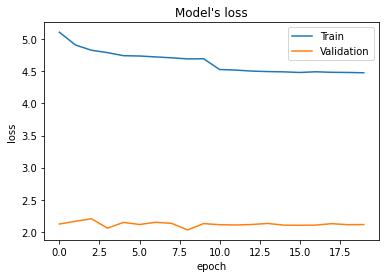

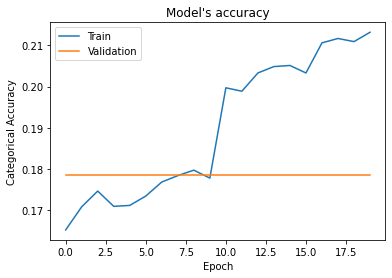

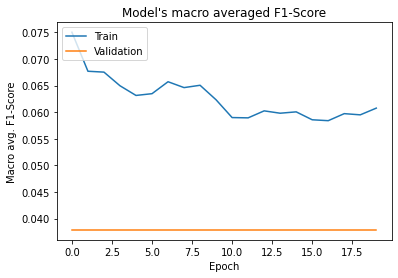

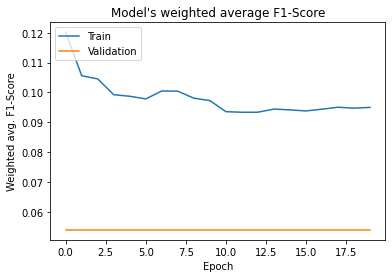

In [ ]:
# # Summarize history for loss
# plt.plot(top_history['loss'])
# plt.plot(top_history['val_loss'])
# plt.title('Model\'s loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()
# print()

# # Summarize history for accuracy
# plt.plot(top_history['Categorical Accuracy'])
# plt.plot(top_history['val_Categorical Accuracy'])
# plt.title('Model\'s accuracy')
# plt.ylabel('Categorical Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# print()

# # Summarize history for MACRO avg. F1-Score
# plt.plot(top_history['Macro F1'])
# plt.plot(top_history['val_Macro F1'])
# plt.title('Model\'s macro averaged F1-Score')
# plt.ylabel('Macro avg. F1-Score')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# print()

# # Summarize history for weighted avg. F1
# plt.plot(top_history['Weighted F1'])
# plt.plot(top_history['val_Weighted F1'])
# plt.title('Model\'s weighted average F1-Score')
# plt.ylabel('Weighted avg. F1-Score')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

#### Treinamento de todas as camadas

In [7]:
# Load FULL model
model = keras.models.load_model(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull_20")

In [ ]:
# # Unfreeze all layer's pretrained weights
# for layer in model.layers:
#     layer.trainable = True

# # Learning rate scheduler (starts at 10^(-3) and drops by a factor of 10^(-1)
# # every 10 epochs)
# lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=827*10,
#     decay_rate=0.1,
#     staircase=True)

# # Optimizer setup
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# # Metrics
# metrics = [CategoricalAccuracy(name='Categorical Accuracy'),
#            micro_f1, macro_f1, weighted_f1]

# # Compile model
# model.compile(optimizer=optimizer, loss="categorical_crossentropy",
#               metrics=metrics)

In [8]:
# Learning rate scheduler (starts at 10^(-3) and drops by a factor of 10^(-1)
# every 10 epochs)
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=827*10,
    decay_rate=0.1,
    staircase=True)

# Optimizer setup
model.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# # Change learning rate after a few epochs of training
# LEARNING_RATE = 1e-3
# K.set_value(model.optimizer.learning_rate, LEARNING_RATE)

# # Change BETA_1 hyperparameter
# BETA_1 = 0.9
# K.set_value(model.optimizer.beta_1, BETA_1)

# # Change BETA_2 hyperparameter
# BETA_2 = 0.999
# K.set_value(model.optimizer.beta_2, BETA_2)

# Verify changes
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': {'class_name': 'ExponentialDecay',
  'config': {'decay_rate': 0.1,
   'decay_steps': 8270,
   'initial_learning_rate': 0.0001,
   'name': None,
   'staircase': True}},
 'name': 'Adam'}

In [9]:
# # Train with callback (early stopping)
# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=20, restore_best_weights=True)

# Save whole model's state based on validation loss (best only)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull{epoch:02d}",
    monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

In [ ]:
# ALL layers training (CHECK 'epochs' and 'initial_epoch' before start)
history = model.fit(train_generator, validation_data=val_generator, epochs=40,
                    class_weight=class_weights,
                    callbacks=[checkpoint],
                    initial_epoch=20)

Epoch 21/40
827/827 [==============================] - 994s 1s/step - loss: 0.5442 - Categorical Accuracy: 0.8255 - Micro F1: 0.8255 - Macro F1: 0.7421 - Weighted F1: 0.8153 - val_loss: 3.3228 - val_Categorical Accuracy: 0.2456 - val_Micro F1: 0.2456 - val_Macro F1: 0.0774 - val_Weighted F1: 0.2629

Epoch 00021: val_loss improved from inf to 3.32280, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull21
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull21/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull21/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/40
827/827 [==============================] - 944s 1s/step - loss: 0.5005 - Categorical Accuracy: 0.8392 - Micro F1: 0.8392 - Macro F1: 0.7525 - Weighted F1: 0.8294 - val_loss: 3.1609 - val_Categorical Accuracy: 0.2086 - val_Micro F1: 0.2086 - val_Macro F1: 0.0651 - val_Weighted F1: 0.2256

Epoch 00022: val_loss improved from 3.32280 to 3.16095, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull22
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull22/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull22/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/40
827/827 [==============================] - 939s 1s/step - loss: 0.4460 - Categorical Accuracy: 0.8537 - Micro F1: 0.8537 - Macro F1: 0.7727 - Weighted F1: 0.8448 - val_loss: 2.7505 - val_Categorical Accuracy: 0.4185 - val_Micro F1: 0.4185 - val_Macro F1: 0.0878 - val_Weighted F1: 0.3278

Epoch 00023: val_loss improved from 3.16095 to 2.75045, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull23
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull23/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull23/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/40
827/827 [==============================] - 932s 1s/step - loss: 0.4126 - Categorical Accuracy: 0.8640 - Micro F1: 0.8640 - Macro F1: 0.7814 - Weighted F1: 0.8555 - val_loss: 1.7116 - val_Categorical Accuracy: 0.6293 - val_Micro F1: 0.6293 - val_Macro F1: 0.3598 - val_Weighted F1: 0.5782

Epoch 00024: val_loss improved from 2.75045 to 1.71161, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull24
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull24/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull24/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/40
827/827 [==============================] - 928s 1s/step - loss: 0.3704 - Categorical Accuracy: 0.8770 - Micro F1: 0.8770 - Macro F1: 0.7923 - Weighted F1: 0.8689 - val_loss: 2.7808 - val_Categorical Accuracy: 0.5055 - val_Micro F1: 0.5055 - val_Macro F1: 0.1781 - val_Weighted F1: 0.4089

Epoch 00025: val_loss did not improve from 1.71161
Epoch 26/40
827/827 [==============================] - 929s 1s/step - loss: 0.3360 - Categorical Accuracy: 0.8859 - Micro F1: 0.8859 - Macro F1: 0.8013 - Weighted F1: 0.8783 - val_loss: 2.4766 - val_Categorical Accuracy: 0.4611 - val_Micro F1: 0.4611 - val_Macro F1: 0.2538 - val_Weighted F1: 0.4660

Epoch 00026: val_loss did not improve from 1.71161
Epoch 27/40
827/827 [==============================] - 935s 1s/step - loss: 0.3115 - Categorical Accuracy: 0.8946 - Micro F1: 0.8946 - Macro F1: 0.8110 - Weighted F1: 0.8877 - val_loss: 3.7724 - val_Categorical Accuracy: 0.3184 - val_Micro F1: 0.3184 - val_Macro F1: 0.0847 - val_Weighted F1: 0.2

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull31/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/40
827/827 [==============================] - 948s 1s/step - loss: 0.1812 - Categorical Accuracy: 0.9341 - Micro F1: 0.9341 - Macro F1: 0.8524 - Weighted F1: 0.9290 - val_loss: 1.0966 - val_Categorical Accuracy: 0.7463 - val_Micro F1: 0.7463 - val_Macro F1: 0.5664 - val_Weighted F1: 0.7404

Epoch 00032: val_loss improved from 1.23545 to 1.09662, saving model to /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull32
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull32/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull32/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/40
827/827 [==============================] - 951s 1s/step - loss: 0.1861 - Categorical Accuracy: 0.9343 - Micro F1: 0.9343 - Macro F1: 0.8498 - Weighted F1: 0.9290 - val_loss: 1.2105 - val_Categorical Accuracy: 0.7179 - val_Micro F1: 0.7179 - val_Macro F1: 0.5526 - val_Weighted F1: 0.7150

Epoch 00033: val_loss did not improve from 1.09662
Epoch 34/40
524/827 [==================>...........] - ETA: 5:21 - loss: 0.1790 - Categorical Accuracy: 0.9351 - Micro F1: 0.9351 - Macro F1: 0.8603 - Weighted F1: 0.9303

In [ ]:
# Open csv with top layers' training metrics
history_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug_2adamHistory.csv")

# Make new dataframe with current values
new_entries = pd.DataFrame.from_dict(history.history)

# # Append new values to old dataframe
history_df = history_df.append(new_entries, ignore_index=True)

# Save metrics' history as CSV
history_df.to_csv(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug_2adamHistory.csv",
    index=False)

In [ ]:
# Save whole model (CHECK CURRENT EPOCH BEFORE SAVING)
model.save(
    "/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull_40")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull_20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug2_adamFull_20/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


##### Resultados

Valores de perda do conjunto de treino e de validação

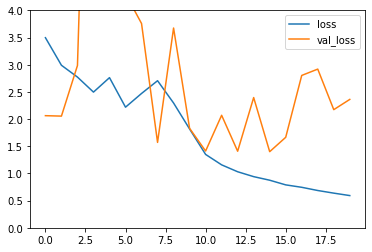

In [ ]:
# history_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_dataAug_2adamHistory.csv")
history_df.plot(y=['loss', 'val_loss'], ylim=(0, 3.5))

Valores de perda do conjunto de validação

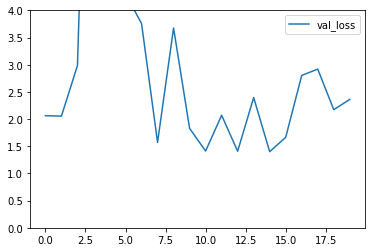

In [ ]:
history_df.plot(y='val_loss', ylim=(0, 3.5))

Todas as métricas

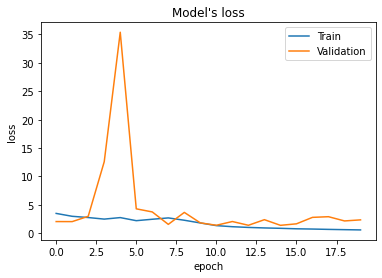

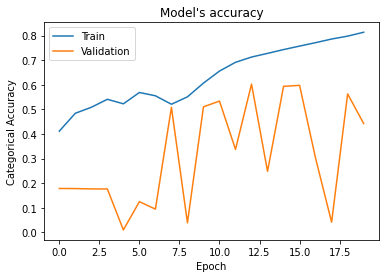

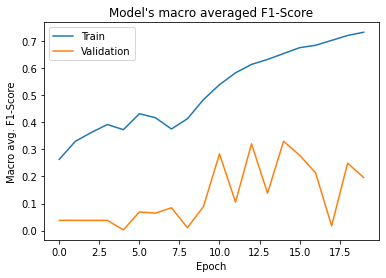

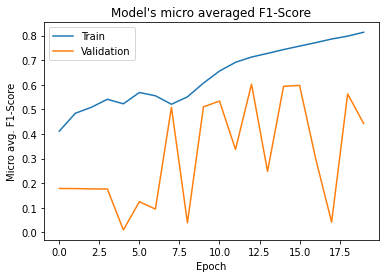

In [ ]:
# history_df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/skinLesionClass/models/effNetB2_history.csv")

# Summarize history for loss
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model\'s loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print()

# Summarize history for accuracy
plt.plot(history_df['Categorical Accuracy'])
plt.plot(history_df['val_Categorical Accuracy'])
plt.title('Model\'s accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for MACRO avg. F1-Score
plt.plot(history_df['Macro F1'])
plt.plot(history_df['val_Macro F1'])
plt.title('Model\'s macro averaged F1-Score')
plt.ylabel('Macro avg. F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print()

# Summarize history for MICRO avg. F1
plt.plot(history_df['Micro F1'])
plt.plot(history_df['val_Micro F1'])
plt.title('Model\'s micro averaged F1-Score')
plt.ylabel('Micro avg. F1-Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testes

### Modelo p/ copiar e colar

*   Batch size: 32;
*   Topo treinado por XX épocas;
*   Número de épocas de treinamento: YY;
*   *Learning rate*: ZZ;

In [ ]:
# import matplotlib.pyplot as plt

# from sklearn.metrics import classification_report

In [ ]:
# Predicts labels
# test_predictions = model.predict(test_generator, verbose=1)

In [ ]:
print(classification_report(test_generator.labels.argmax(1),
                            # test_predictions.argmax(1), zero_division=0))

In [ ]:
# # Confusion matrix
# confusion = tf.math.confusion_matrix(test_generator.labels.argmax(1),
#                                      test_predictions.argmax(1))

# plt.matshow(confusion)